## PSSET 2
### Minjia Zhu

In [117]:
import os
import struct
import numpy as np
from matplotlib import pyplot

import matplotlib as mpl
import random
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import confusion_matrix
#Fashion-MNIST classes (mapping from class index to class name)
class_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# some utilities

def create_submission_file(fname, preds):
    """
    Create Kaggle submision with predictions written as a csv (comma separated values) file 
    """
    
    ofile  = open(fname, "w")
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)    
    
    writer.writerow(['id', 'label'])
    
    
    for i in range(preds.shape[0]):
        writer.writerow([i,preds[i]])
        

        
def read_fMNIST(dataset = "training", path = "./", load_small=False):
    """
    reading in the "Fashion MNIST" data
    this function allows specification of the part to be read (training/testing/validation)
    if load_small = True, this will look for the file(s) associated with the small training set
    Note that if dataset='testing', no labels will be returned
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'Te'
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    if load_small:
        file_name_suffix += '_sm'
    
    #Load the appropriate files
    X = np.load('./x'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load('./y'+file_name_suffix+'.npy')
    

    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X



def show_fMNIST_example(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    image = image[-28**2:]
    image = image.reshape(28,28)

    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.axis('off')
    pyplot.show()
    

Let's look at some images

Training images
Class: bag


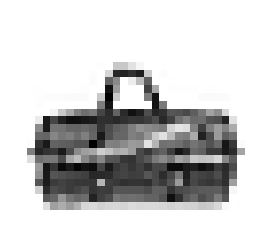

Class: shirt


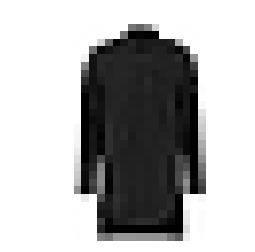

Validation images
Class: bag


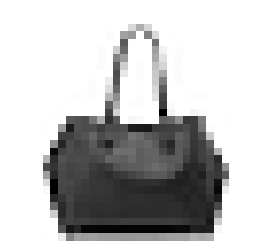

Class: sandal


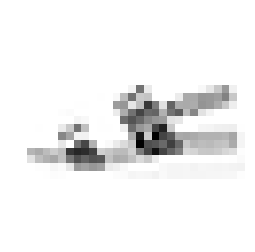

In [104]:

X,y = read_fMNIST('training')
print('Training images')
print('Class: %s'%class_names[np.argmax(y[10])])
show_fMNIST_example(X[10])
print('Class: %s'%class_names[np.argmax(y[20])])
show_fMNIST_example(X[20])


X,y = read_fMNIST('validation')
print('Validation images')
print('Class: %s'%class_names[np.argmax(y[10])])
show_fMNIST_example(X[10])
print('Class: %s'%class_names[np.argmax(y[20])])
show_fMNIST_example(X[20])



Now we will build the code for our softmax model

In [105]:
def softmax(scores):
    """
    takes the softmax along the second dimension of a matrix, returns class scores
    """
    # we will adjust the dynamic range by subtracting the max, to prevent potential underflow in exp
    exp_scores = np.exp(scores-np.max(scores,axis=1,keepdims=True))+1e-6
    return exp_scores/(np.sum(exp_scores,axis=1,keepdims=True))


def log_likelihood(X,w,y):
    """
    Inputs: 
      X: a Nxd matrix where each of the N rows is a datapont with d features
      Y: a Nx10 matrix, each row is a one-hot vector with the ith entry is 1 if that datapoint belongs to class i 
      w: is a dx1 matrix containing your model parameters
    Outputs:
      LL: a scalar containing the AVERAGE log-likelihood of the dataset's labels y, given inputs X and model w
    """
    #compute the un-normalized 'scores' of each class for each datapoint
    scores = infer(X,w)
    
    #normalize the scores to get a distribution over classes for each datapoint
    predictions = softmax(scores)
        
    #Use the predicted distributions, and the true distributions to compute log-likelihood
    N = X.shape[0]
    LL = -(1/N)*np.log(np.sum(y*predictions))

    return LL

def objective(X,w,y):
    """
    Compute components of the optimization objective
    Output:
    logloss : value of log-loss (negative average log-likelihood)
    regularizer: value of the regularization term (Frobenius norm of w), NOT multiplied by lambda
    """
    regularizer = np.linalg.norm(w,'fro')
    logloss = - log_likelihood(X,w,y)
    return logloss, regularizer



def gradient(X,w,y):
    """
    Compute in grad the gradient of the log-loss of the model (w) given the features (X) and labels (y) w.r.t. w
    Also compute and return in l2grad the gradient of the regularizer lambda*norm(w)
    Note: we can't use the name 'lambda' since it's a keyword in Python
    Reminder: the full objective is -log p(y|X;w) + lmbda*norm2(w)
    """
    
    #Compute any extra variable needed to compute the gradient:
    scores = np.dot(X,w)
    predictions = softmax(scores)

    #Compute the gradient of the average log-loss
    N = X.shape[0]
    grad = (1/N)*np.dot(predictions.T-y.T,X).T
    l2grad = 2*w
    
    return grad, l2grad

def infer(X,w):
    """
    Compute the class scores that model w gives for each class, given data X
    """
    scores = np.dot(X,w)
    return scores

def accuracy(X,w,y):
    """
    Compute accuracy (one minus average 0/1 loss) of model w relative to true labels y on data X
    """
    y_hat = np.argmax(infer(X,w),axis=1)
    y = np.argmax(y,axis=1)
    acc = np.sum(np.equal(y,y_hat).astype(np.float32))/y.shape[0]
    return acc
        

Now we define the SGD (stochastic gradient descent) procedure for softmax, with optional regularization

In [106]:
def minibatch_sgd(xTr, yTr, xVl, yVl, lmbda=0, lr = .01,maxepochs=10,bsize=32,objTol=.01,verbose=1):
    
    # initialization of w (feel free to play with this)
    w = np.zeros((xTr.shape[1],yTr.shape[1]))
    
    old_obj = 1e9  
    old_w = w
    
    # we will organize the run in terms of epochs (one epcoh = one full pass over data)
    # to keep track of learning curves, allocate space
    trAcc = np.zeros(maxepochs)
    obj = np.zeros(maxepochs)
    
    for epoch in range(maxepochs):
        
        #shuffle the data
        index = np.random.permutation(xTr.shape[0])
        nBatches = np.floor(xTr.shape[0]/bsize).astype(np.integer) # ignore the remainder N-floor(N/bsize), for simplicity
    
        for b in range(nBatches):
            # fill in the batch
            iBatch = index[b*bsize:(b+1)*bsize]
            xBatch = xTr[iBatch]
            yBatch = yTr[iBatch]
            
            grad,l2grad = gradient(xBatch,w,yBatch)
    
            w = w-lr*(grad+lmbda*l2grad)
            
        
        # end of an epoch: test for convergence by looking at validation
        logloss, regularizer = objective(xTr,w,yTr)
        obj[epoch] = logloss+lmbda*regularizer
                
        # also record accuracy on training
        trAcc[epoch] = accuracy(xTr,w,yTr)

        obj_gain = (old_obj-obj[epoch])/np.abs(old_obj) # improvement in training objective this epich
        
        if verbose > 0.5:
            print('Epoch %d: obj=%.4f, gain %.4f  [train acc %.4f]'%(epoch,obj[epoch],obj_gain,trAcc[epoch]))
        
        
        if epoch == maxepochs-1:
            if verbose > 0:
                print('Reached max epochs, stopping')
            return w, obj, trAcc
        
        if obj_gain < objTol:  
            lr = lr/2
            if verbose > 0:
                print('Dropping learning rate to %.4f'%lr)
        
        # update bookkeeping before going to next epoch
        old_obj = obj[epoch]     

Before we can start experiments, we need one more piece: feature transform. In this case we are using the "raw" features (pixel values) plus the constant term, but with normalization that applies z-scoring to each pixel.

In [107]:
# if mu and sigma are provided, they are used to normalize each pixel
# otherwise, they are computed and returned
def preprocess_data(X,mu = None,sigma = None,visualize=False):

    if visualize:
        print('VISUALIZE BEFORE NORMALIZATION')
        #Visualize example before normalization
        show_fMNIST_example(X[300])
        show_fMNIST_example(X[500])
    
    if mu is None: # need to compute normalizing stats
        compute_stats = True
        mu = X.mean(axis=0, keepdims=True)
        sigma = X.std(axis=0, keepdims=True)
        sigma[np.equal(sigma,0)]=1.0 # avoid division by zero in case of degenerate features
    else:
        compute_stats = False
        
    #Normalize the data
    X = (X-mu)/sigma
    bias_feature = np.ones((X.shape[0],1))
    X = np.concatenate([np.ones((X.shape[0],1)),X],1)

    if visualize:
        print('VISUALIZE AFTER NORMALIZATION')
        #Visualize example after normalization
        show_fMNIST_example(X[300])
        show_fMNIST_example(X[500])
    
    if compute_stats:
        return X, mu, sigma
    else:
        return X




VISUALIZE BEFORE NORMALIZATION


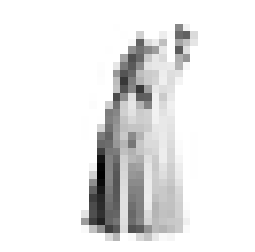

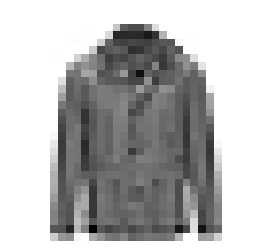

VISUALIZE AFTER NORMALIZATION


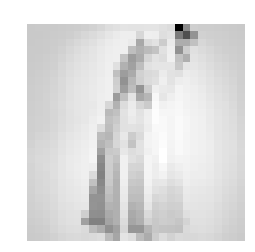

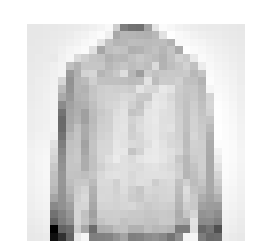

In [108]:
xTr, yTr = read_fMNIST('Training')
xTr, mu, sigma = preprocess_data(xTr,visualize=True)

We now define the main routine for our experiments: load training/validation data sets, and tune the regularization parameter (and perhaps other parameters you want to tune)

In [109]:
# run minibatch SGD for every value of lambda and record training/val accuracy
def tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt):
    
    obj=dict()
    trAcc=dict()
    model=dict()
    valAcc=dict()

    for lmbda in lambdas:
        model[lmbda], obj[lmbda],trAcc[lmbda] = minibatch_sgd(xTr,yTr,xVl,yVl,lmbda, sgd_opt['lr'],sgd_opt['maxepochs'],sgd_opt['bsize'],verbose=sgd_opt['verbose'])
        valAcc[lmbda] = accuracy(xVl,model[lmbda],yVl)
        if sgd_opt['verbose'] >= 0:
            print('-------------- lambda=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(lmbda,valAcc[lmbda],trAcc[lmbda][-1]))
        
    return model, obj, trAcc, valAcc

# Large Data Set

In [138]:
xTr, yTr = read_fMNIST('Training')
xVl, yVl = read_fMNIST('Validation')

xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

# values below are a recommendation for initial exploration -- you should see if you want to refine these

lambdas = [0,.0001,.001,.01,.1,1.0,5,10.0]
sgd_opt = {'bsize':16, 'maxepochs':20, 'lr':.1,'verbose':0}

model, obj, trAcc, valAcc = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)
#Select the largest accuracy in validation set (related to the optimum lambda of the penalization)
best_l = max(valAcc,key = valAcc.get)

-------------- lambda=0.00000, val Acc = 0.8493  (tr Acc = 0.8795)
-------------- lambda=0.00010, val Acc = 0.8513  (tr Acc = 0.8819)
-------------- lambda=0.00100, val Acc = 0.8547  (tr Acc = 0.8759)
-------------- lambda=0.01000, val Acc = 0.8484  (tr Acc = 0.8595)
-------------- lambda=0.10000, val Acc = 0.8172  (tr Acc = 0.8238)
-------------- lambda=1.00000, val Acc = 0.7428  (tr Acc = 0.7479)
-------------- lambda=5.00000, val Acc = 0.6892  (tr Acc = 0.6964)
-------------- lambda=10.00000, val Acc = 0.6700  (tr Acc = 0.6753)


###  Best Model Result

In [139]:
print('best model selected:')
print('bsize:16, maxepochs:20, lr:.1')
print('lambda=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(best_l,valAcc[best_l],trAcc[best_l][-1]))

best model selected:
bsize:16, maxepochs:20, lr:.1
lambda=0.00100, val Acc = 0.8547  (tr Acc = 0.8759)


### Confusion Matrix

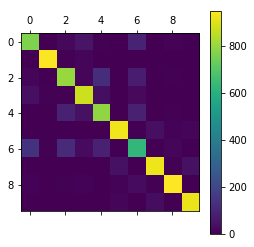

In [140]:
final_preds_x = np.argmax(infer(xVl,model[best_l]),axis=1)
actual_training_y = [np.where(r==1)[0][0] for r in yVl]
conf_matrix = confusion_matrix(actual_training_y, final_preds_x)
plt.matshow(conf_matrix)
plt.colorbar()
plt.show()

### Show W

tshirt/top
0


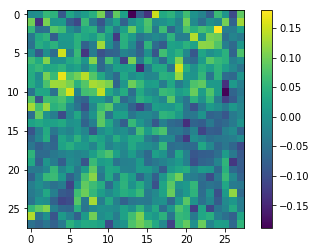

trouser
1


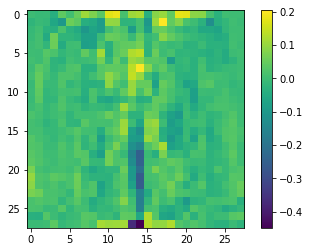

pullover
2


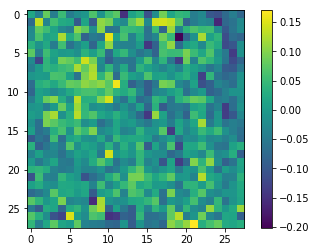

dress
3


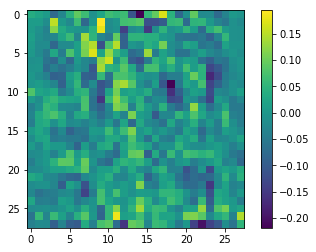

coat
4


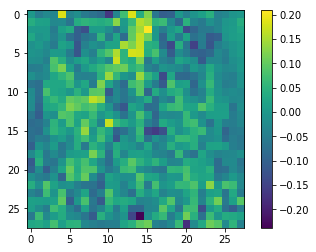

sandal
5


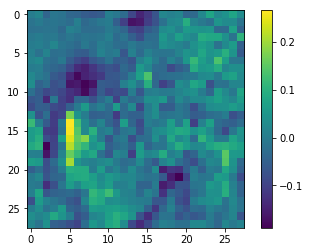

shirt
6


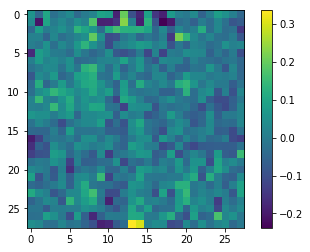

sneaker
7


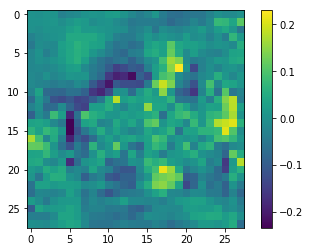

bag
8


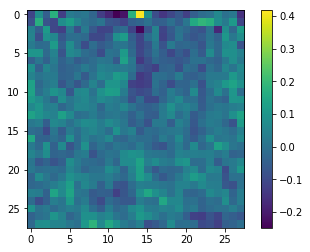

ankle boot
9


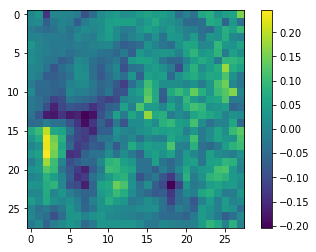

In [141]:
c = 0
for i in class_names:
    print(i)
    print(c)
    plt.imshow(model[best_l][1:,c].reshape(28,28))
    plt.colorbar()
    plt.show()
    c += 1

#### Above graphes shows values of wc associated with each class in model W, from whicih we can observe difference with different classes. We can observe pattern/color scheme among different class. We can see class 1,5,9 have more distinct pattern than others. Probably that is the reason why confusion matrix shows that we are predicting class 1,5,9 better than other calsses. 

In [142]:
xTe = read_fMNIST('testing')
xTe = preprocess_data(xTe,mu,sigma,visualize=False)


#Decide which model you want to use for your submission
chosen_model = model[best_l]

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model),axis=1)
create_submission_file('./large_submission.csv', final_preds)

## Small Dataset

Now we will repeat this experiment with the small training set

In [157]:
xTr, yTr = read_fMNIST('Training', load_small=True)
xVl, yVl = read_fMNIST('Validation')


xTr,mu,sigma = preprocess_data(xTr,visualize=False)
xVl = preprocess_data(xVl,mu,sigma,visualize=False)

lambdas = [0,.0001,.001,.01,.1,1.0,10.0,200]
sgd_opt = {'bsize':1, 'maxepochs':30, 'lr':.1,'verbose':0}

model, obj, trAcc, valAcc = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)

-------------- lambda=0.00000, val Acc = 0.5011  (tr Acc = 1.0000)
-------------- lambda=0.00010, val Acc = 0.4721  (tr Acc = 1.0000)
-------------- lambda=0.00100, val Acc = 0.5202  (tr Acc = 1.0000)
-------------- lambda=0.01000, val Acc = 0.5107  (tr Acc = 1.0000)
-------------- lambda=0.10000, val Acc = 0.5674  (tr Acc = 1.0000)
-------------- lambda=1.00000, val Acc = 0.5725  (tr Acc = 1.0000)
-------------- lambda=10.00000, val Acc = 0.5602  (tr Acc = 1.0000)
-------------- lambda=200.00000, val Acc = 0.4317  (tr Acc = 0.8667)


In [147]:
#Select the largest accuracy in validation set (related to the optimum lambda of the penalization)
print('best model selected:')
print('bsize:1, maxepochs:30, lr:.1')
print('lambda=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(best_s,valAcc[best_s],trAcc[best_s][-1]))

best model selected:
bsize:1, maxepochs:30, lr:.1
lambda=0.10000, val Acc = 0.5766  (tr Acc = 1.0000)


In [146]:
xTe = read_fMNIST('testing')
xTe = preprocess_data(xTe,mu,sigma,visualize=False)


#Decide which model you want to use for your submission
chosen_model = model[best_s]

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model),axis=1)
create_submission_file('./small_submission.csv', final_preds)

## Observation and conclusion 

In large dataset, val Acc = 0.8547, tr Acc = 0.8759.
In small dataset, val Acc = 0.5766, tr Acc = 1.0000. 
The accuracy of validation set and testing set are not much different for large dataset, but significant for small dataset. This implies that we do not have a good estimation given samll dataset, probably due to overfitting issue. While increase in N could overcome this issue,regularizastion also plays more role in large dataset because the effect of 1/N makes the large dataset regularize more. 